In [1]:
source("analysis/slicec.R", chdir=TRUE)

library(broom)
library(cowplot)
library(dplyr)
library(ggplot2)
library(ggrepel)
# library(lazyeval)
library(reshape2)
library(tidyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [3]:
top.quartile <- function(x) quantile(x, 0.75)
bottom.quartile <- function(x) quantile(x, 0.25)

In [4]:
speedup.plot <- function(speedup.df, x.name) {
    ggplot(speedup.df, aes_(x=x.name, y=quote(speedup), label=quote(sprintf("%.2f",speedup)))) +
        geom_line() +
        geom_text(vjust="outward", hjust="center", size=5) +
        labs(y="Speedup") +
        theme_cowplot(font_size=20)
}

In [5]:
runtime.plot <- function(runtime.df, x.name) {
    top.quartile <- function(x) quantile(x, 0.75)
    bottom.quartile <- function(x) quantile(x, 0.25)
    
    ggplot(runtime.df, aes_(x=x.name, y=quote(mean.seconds), colour=quote(compiler), linetype=quote(compiler))) + 
        stat_summary(fun.y="mean", geom="line", size=2) +
        stat_summary(fun.ymax=top.quartile, fun.ymin=bottom.quartile, geom="errorbar", size=2) +
        guides(colour=guide_legend("Compiler"), linetype=guide_legend("Compiler")) +
          scale_color_manual(values=colour.blind.friendly.values(),
                         labels=c("ifort", "slicec")) +
        scale_linetype_discrete(labels=c("ifort", "slicec")) +
        labs(y="Run-time [s]") +
        theme_cowplot(font_size=20)
}

In [6]:
speedup.runtime.plot <- function(speedup.df, runtime.df, x.name) {
    
    p1 <- ggplot(speedup.df, aes_(x=x.name, y=quote(speedup), label=quote(sprintf("%.2f",speedup)))) +
        geom_line() +
        geom_text_repel(size=5) +
        labs(y="Speedup") +
        theme_cowplot(font_size=14)
    top.quartile <- function(x) quantile(x, 0.75)
    bottom.quartile <- function(x) quantile(x, 0.25)
    p2 <- ggplot(runtime.df, aes_(x=x.name, y=quote(mean.seconds), colour=quote(compiler), linetype=quote(compiler))) + 
        stat_summary(fun.y="mean", geom="line", size=1) +
        stat_summary(fun.ymax=top.quartile, fun.ymin=bottom.quartile, geom="errorbar", size=1.5) +
        guides(colour=guide_legend("Compiler"), linetype=guide_legend("Compiler")) +
          scale_color_manual(values=colour.blind.friendly.values(),
                         labels=c("ifort", "slicec")) +
        scale_linetype_discrete(labels=c("ifort", "slicec")) +
        labs(y="Run-time [s]") +
        theme_cowplot(font_size=14)
    p <- plot_grid(p1, p2, align="h")
    p
}

# Parameter deductions

## Estimating $T^C$  and $T^O$

Command run:
`for u in $(seq 1 16); do ./run_forts.py --runs 1 --repetitions 200 -n 256 -n 256 -r 128 -r 64 -a 1 -a 1 -a 1 -s 1 -s 1 -s 1 -sizes 500000 -element-sizes 8  -o rofl.org -M 300 -Tc 9 -To 5 -Cmax $u -Cmin $u -Vmin 1; done`

Binaries disassembled (function `do_slicec_slice_`):

- Unroll 1:  bin/slicec_cmp_29fdb1e4bdef7a42f2d4ceff50c5f080
- Unroll 2:  bin/slicec_cmp_e597476456373fc90bd820c1bf8be3d5
- Unroll 3:  bin/slicec_cmp_0ab01b047beebee346ae7afb2c5ff6d1
- Unroll 4:  bin/slicec_cmp_f2143424164a0b138e4dd78cec040c0d
- Unroll 5:  bin/slicec_cmp_b899556d29fe69559329c3883841b29b
- Unroll 6:  bin/slicec_cmp_ed07ac6bbc845557fdf81cb6c5fbdcaf
- Unroll 7:  bin/slicec_cmp_ea4b48ac73e5ed172d9adc2cc5e6847f
- Unroll 8:  bin/slicec_cmp_4f10c45465a6447536c644eefedf45aa
- Unroll 9:  bin/slicec_cmp_e06fc2ac3587a72ced2a33e195d274c7
- Unroll 10: bin/slicec_cmp_479fa13979293b22c7db734b82873770
- Unroll 11: bin/slicec_cmp_b981d1307e6ee7fd2f754603123ac78e
- Unroll 12: bin/slicec_cmp_ba41105df1cd8fd6b618908ea2599b24
- Unroll 13: bin/slicec_cmp_22cdb60fd1cfa65793e181a33813c872
- Unroll 14: bin/slicec_cmp_931f96f34f07968a568bd2435a4aad52
- Unroll 15: bin/slicec_cmp_5bcbb28e6ab52a4ae461c7b2a502005a
- Unroll 16: bin/slicec_cmp_ecdd5de965ea67c50374f6474f9e1536

In [7]:
loop.body.instruction.count <- data.frame(
    unroll.count = 1:8,
    instructions.in.body = c(
             14, # 1
    24, # 2
    37, # 3
    51, # 4
    70, # 5
    86, # 6
    103, # 7
    119#, # 8
    #249, # 9
    #237,
    #254,
    #273,
    #288,
    #304,
    #317,
    #332
    )
)

In [8]:
lm(instructions.in.body ~ unroll.count - 1, data=loop.body.instruction.count)


Call:
lm(formula = instructions.in.body ~ unroll.count - 1, data = loop.body.instruction.count)

Coefficients:
unroll.count  
       14.29  


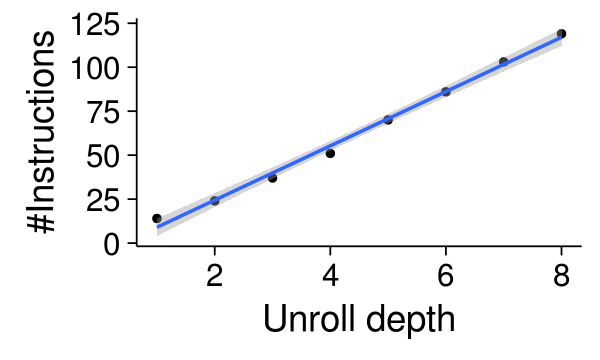

In [9]:
set.plot.size(5,3)
p <- ggplot(loop.body.instruction.count, aes(x=unroll.count, y=instructions.in.body)) +
    geom_point(size=2) +
    geom_smooth(method="lm") +
    labs(x="Unroll depth",
         y="#Instructions") +
    theme_cowplot(font_size=22)
cowplot::save_plot("tc-to-estimate.pdf", p, base_aspect_ratio=2)
p

## Estimating $C^{max}$

We use the same disassembled slicing routines as when estimating $T^C$ and $T^O$.

In [10]:
loop.body.byte.count <- data.frame(
    unroll.count = 1:8,
    bytes.in.body = c(
        72, # 1
        148,   # 2
        234,   # 3
        303,  # 4
        417,  # 5
        536,  # 6
        641,  # 7
        736#,  # 8
       # 1558,  # 9
       # 1262,  # 10
       # 1320,  # 11
       # 1417,  # 12
       # 1500,  # 13
       # 1592,  # 14
       # 1625,  # 15
       # 1738   # 16
    )
)

In [11]:
lm(bytes.in.body ~ unroll.count - 1, data=loop.body.byte.count)


Call:
lm(formula = bytes.in.body ~ unroll.count - 1, data = loop.body.byte.count)

Coefficients:
unroll.count  
       88.03  


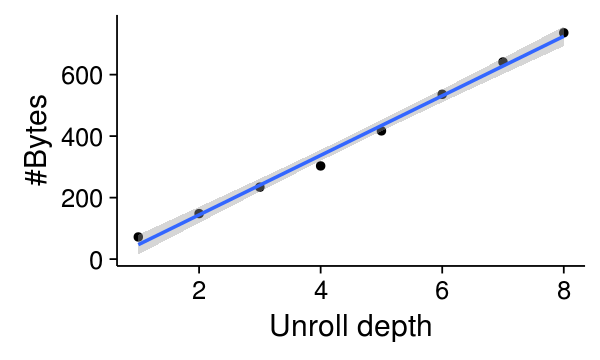

In [12]:
set.plot.size(5,3)
p <- ggplot(loop.body.byte.count, aes(x=unroll.count, y=bytes.in.body)) +
    geom_point(size=2) +
    geom_smooth(method="lm") +
    labs(x="Unroll depth",
         y="#Bytes") +
    theme_cowplot(font_size=18)
cowplot::save_plot("cmax-estimate.pdf", p, base_aspect_ratio=1.3)
p

### Cycles Per Instruction

In [13]:
M.seq <- read.fort.exp.table("results/M_estimate_seq.org")

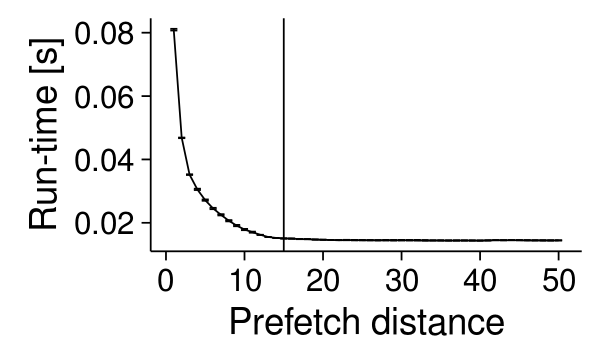

In [14]:
p <- ggplot(filter(M.seq, compiler=="slicec_s"), aes(x=L1_prefetch_dist, y=mean.seconds)) +
    geom_line(stat="summary", fun.y="mean") +
    geom_vline(xintercept = 15) +
    geom_errorbar(stat="summary", fun.ymax="top.quartile", fun.ymin="bottom.quartile") +
    labs(y="Run-time [s]", x="Prefetch distance") +
    theme_cowplot(font_size = 22)
save_plot("Tc-estimate.pdf", p, base_aspect_ratio=2)
p

# Slicing space analysis

## R1 sweep

In [17]:
r1 <- read.fort.exp.table("results/r1_space_sweep.org")

In [18]:
r1.speedup <- calc.speedup(r1, "r1")

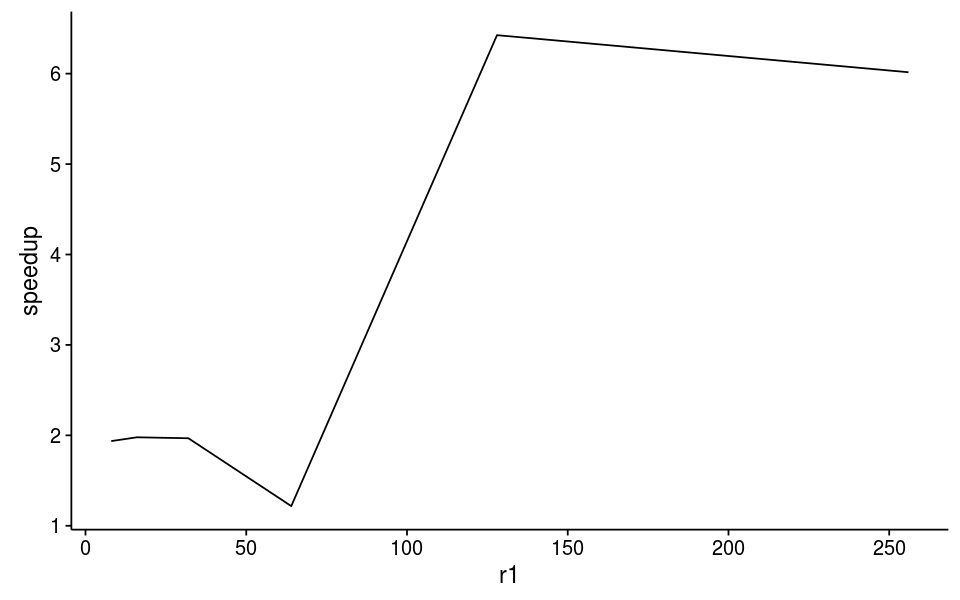

In [19]:
ggplot(r1.speedup, aes(x=r1, y=speedup)) +
    geom_line()

## $s_1$ sweep

In [22]:
s1 <- read.fort.exp.table("results/s1_space_sweep.org")

In [23]:
s1.speedup <- calc.speedup(s1, "s1")

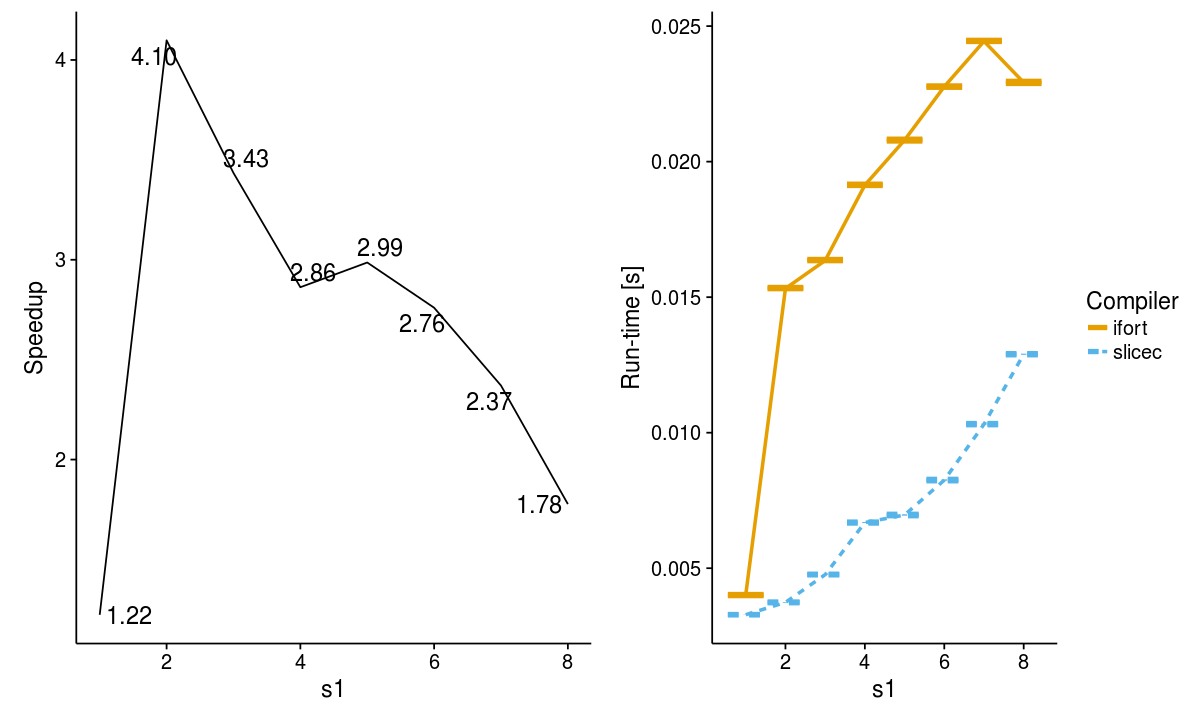

In [24]:
p <- speedup.runtime.plot(s1.speedup, s1, quote(s1))
save_plot("s1-sweep.pdf", p, base_aspect_ratio=3)
set.plot.size(10, 6)
p

## $r_2$ sweep

In [25]:
r2 <- read.fort.exp.table("results/r2_space_sweep.org")

In [26]:
r2.speedup <- calc.speedup(r2, "r2")

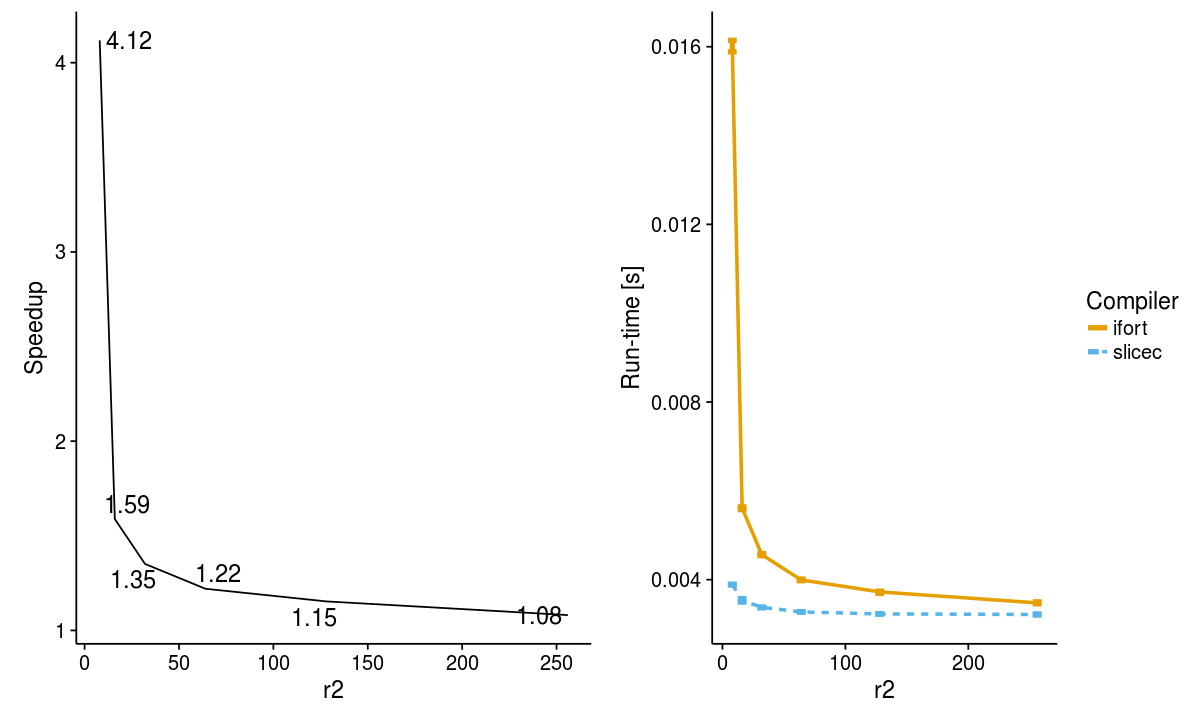

In [27]:
p <-speedup.runtime.plot(r2.speedup, r2, quote(r2))
save_plot("r2-sweep.pdf", p, base_aspect_ratio=3)
set.plot.size(10, 6)
p

## $b_1$ sweep

In [28]:
b1 <- read.fort.exp.table("results/b1_space_sweep.org")

In [29]:
b1.speedup <- calc.speedup(b1, "b1")

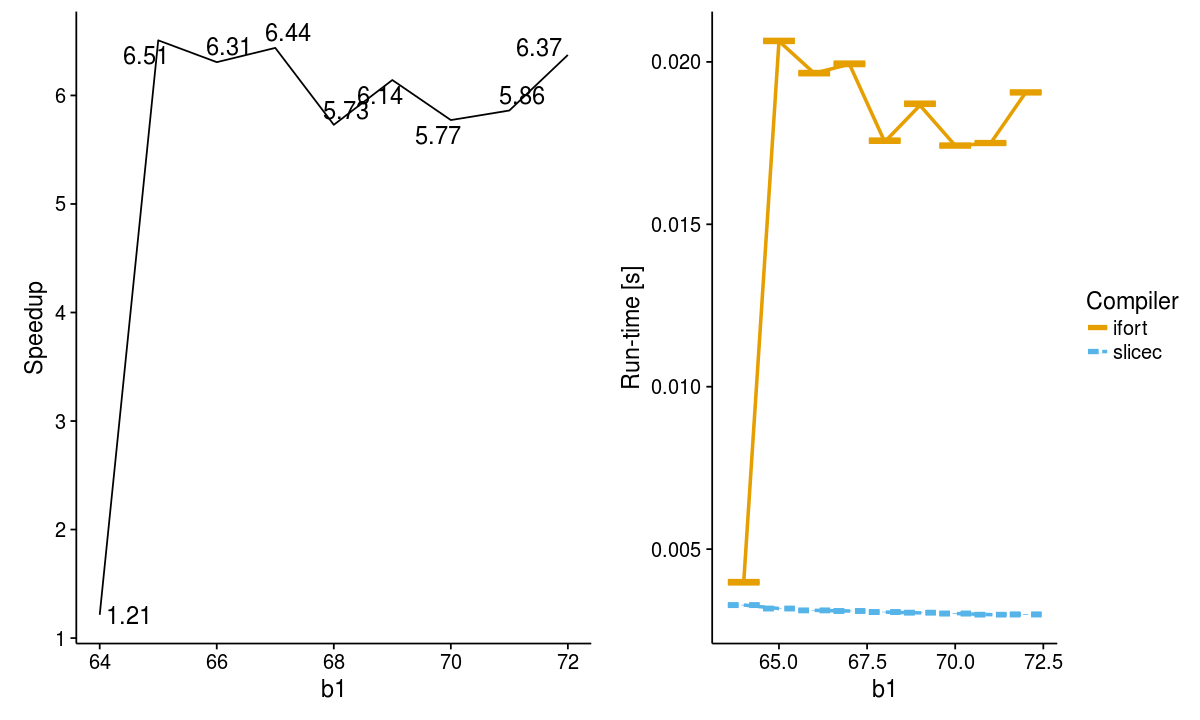

In [30]:
p <- speedup.runtime.plot(b1.speedup, b1, quote(b1))
save_plot("b1-sweep.pdf", p, base_aspect_ratio=3)
set.plot.size(10, 6)
p

## $n_1$ unaligned

In [31]:
n1.unaligned <- read.fort.exp.table("results/n1_space_sweep.org")

In [32]:
n1u.speedup <- calc.speedup(n1.unaligned, "n1")

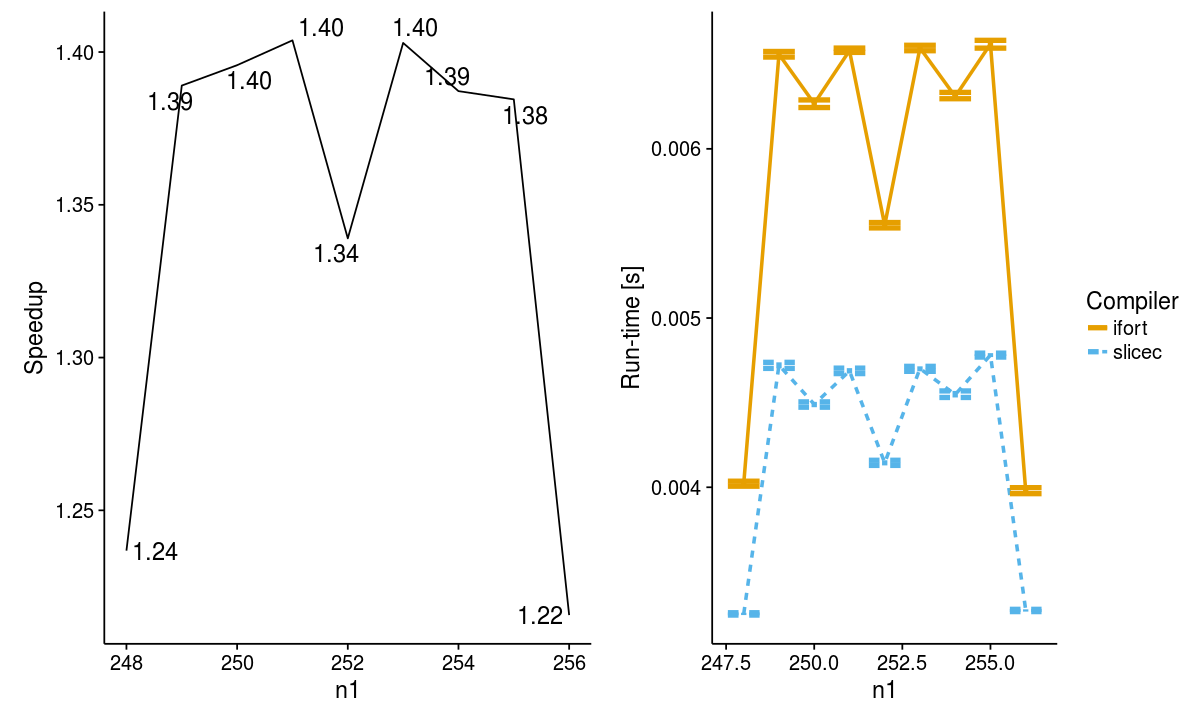

In [33]:
p <- speedup.runtime.plot(n1u.speedup, n1.unaligned, quote(n1))
save_plot("n1-unaligned.pdf", p, base_aspect_ratio=3)
set.plot.size(10, 6)
p


# Application-relevant slicing expressions

In [27]:
top.border <- read.fort.exp.table("results/top_border_2d_same_size.org")

In [28]:
tb.speedup <- calc.speedup(top.border, "r1")

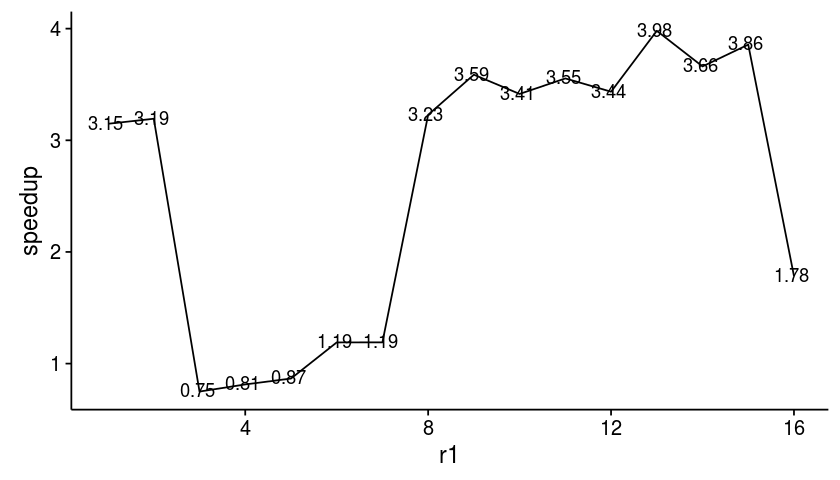

In [41]:
set.plot.size(7, 4)
ggplot(tb.speedup, aes(x=r1, y=speedup, label=sprintf("%.2f", speedup))) +
    geom_line() +
    geom_text(nudge_y = 0.01, nudge_x = -0.05)

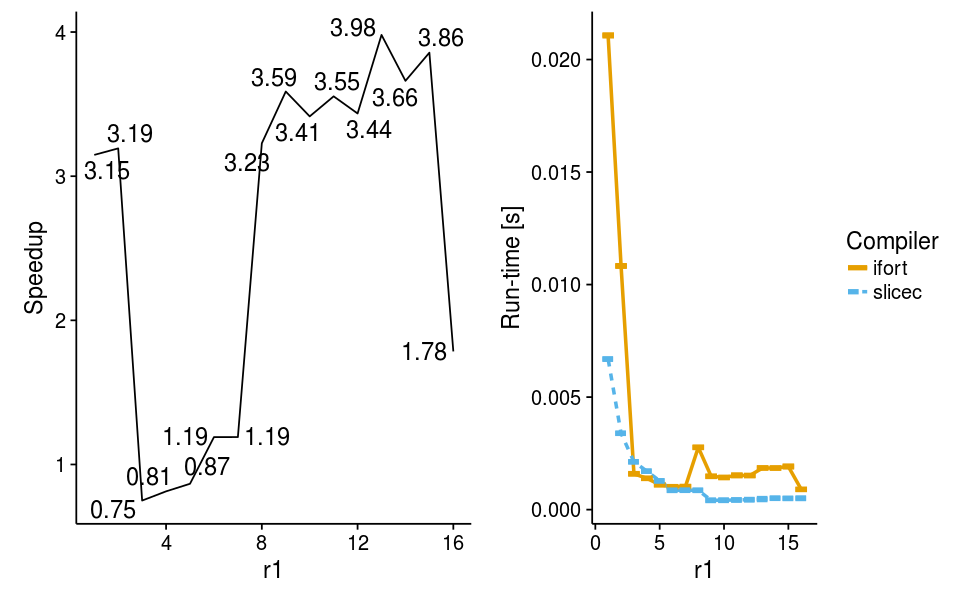

In [43]:
set.plot.size(8, 5)
p <- speedup.runtime.plot(tb.speedup, top.border, quote(r1))
save_plot("top-border-2d-same-size.pdf", p, base_aspect_ratio=3)
p

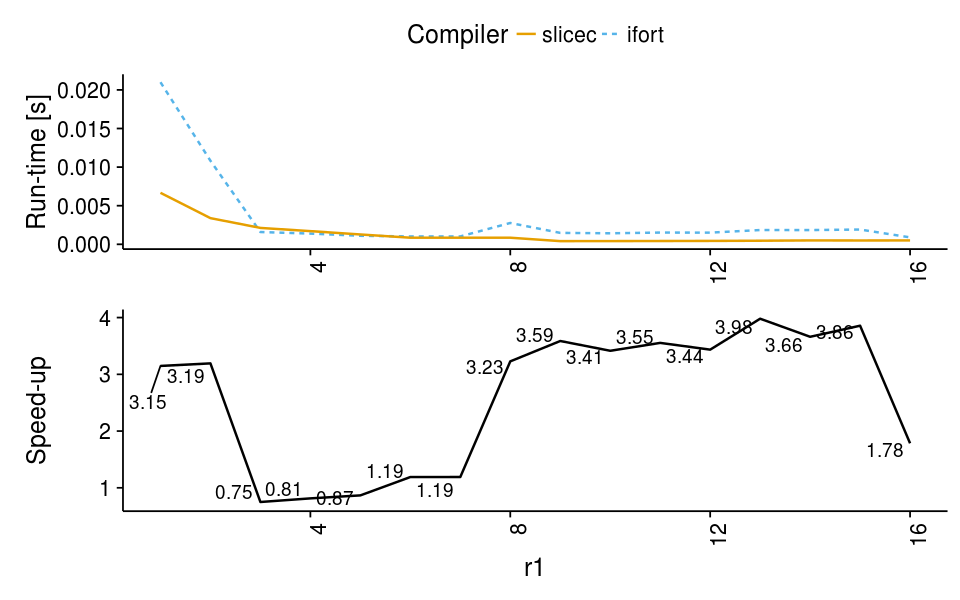

In [29]:
tb.melt <- melt(tb.speedup, measure.vars=c("mean.ifort", "mean.slicec"), 
              value.name = "mean.seconds", variable.name = "compiler")

p1 <- ggplot(tb.melt, aes(x=r1, y=mean.seconds, colour=compiler, linetype=compiler, group=compiler,
                       label=sprintf("%.2f", speedup))) +
    geom_line(size=0.7) +
  #  facet_grid( ~ x.var, scales = "free") +
    guides(colour=guide_legend("Compiler"), linetype=guide_legend("Compiler")) +
    scale_color_manual(values=colour.blind.friendly.values(),
                     labels=c("slicec", "ifort"),
                    limits=c("mean.slicec", "mean.ifort")) +
    scale_linetype_discrete(labels=c("slicec", "ifort"),
                           limits=c("mean.slicec", "mean.ifort")) +
    labs(x=NULL, y="Run-time [s]") +
    theme_cowplot(font_size=15) +
    theme(legend.position="top", panel.spacing = unit(0.2, "lines")) +
    rotate.x.ticks()

library(ggrepel)
p2 <- ggplot(tb.melt, aes(x=r1, y=speedup,
                       label=sprintf("%.2f", speedup))) +
    geom_line(size=0.7) +
    geom_text_repel(stat="summary", fun.y="max", size=4) +
  #  facet_grid( ~ x.var, scales = "free") +
    guides(colour=guide_legend("Compiler"), linetype=guide_legend("Compiler")) +
    scale_color_manual(values=colour.blind.friendly.values(),
                     labels=c("ifort", "slicec")) +
    scale_linetype_discrete(labels=c("ifort", "slicec")) +
    labs(x="r1", y="Speed-up") +
    theme_cowplot(font_size=15) +
    theme(legend.position="top", panel.spacing = unit(0.2, "lines")) +
    theme(strip.background = element_blank(),
           strip.text.x = element_blank()) +
    rotate.x.ticks()


p <- plot_grid(p1, p2, align="v", nrow=2)
save_plot("top-border-v2.pdf", p, base_aspect_ratio = 1.7, device=cairo_pdf)
p

In [48]:
exp(mean(log(tb.speedup$speedup)))

[1] 2.226248

In [30]:
inner1 <- read.fort.exp.table("results/inner_domain_border_1.org")
inner2 <- read.fort.exp.table("results/inner_domain_border_2.org")
inner3 <- read.fort.exp.table("results/inner_domain_border_3.org")
inner4 <- read.fort.exp.table("results/inner_domain_border_4.org")
inner5 <- read.fort.exp.table("results/inner_domain_border_5.org")
inner6 <- read.fort.exp.table("results/inner_domain_border_6.org")
inner7 <- read.fort.exp.table("results/inner_domain_border_7.org")
inner8 <- read.fort.exp.table("results/inner_domain_border_8.org")
inner <- rbind(inner1, inner2, inner3, inner4, inner5, inner6, inner7, inner8)

In [31]:
inner.speedup <- calc.speedup(inner, "a1")

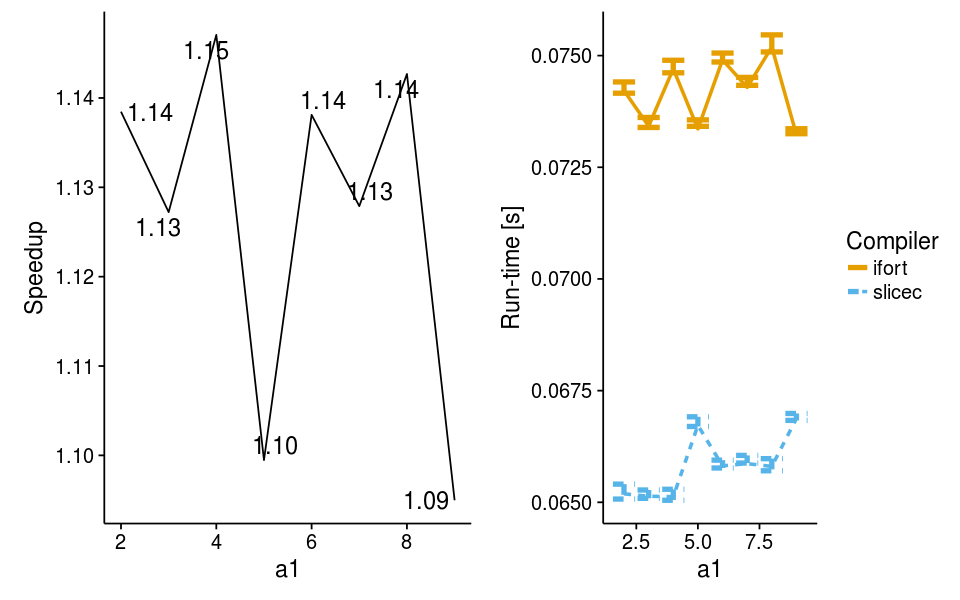

In [47]:
speedup.runtime.plot(inner.speedup, inner, quote(a1))

In [49]:
exp(mean(log(inner.speedup$speedup)))

[1] 1.126835

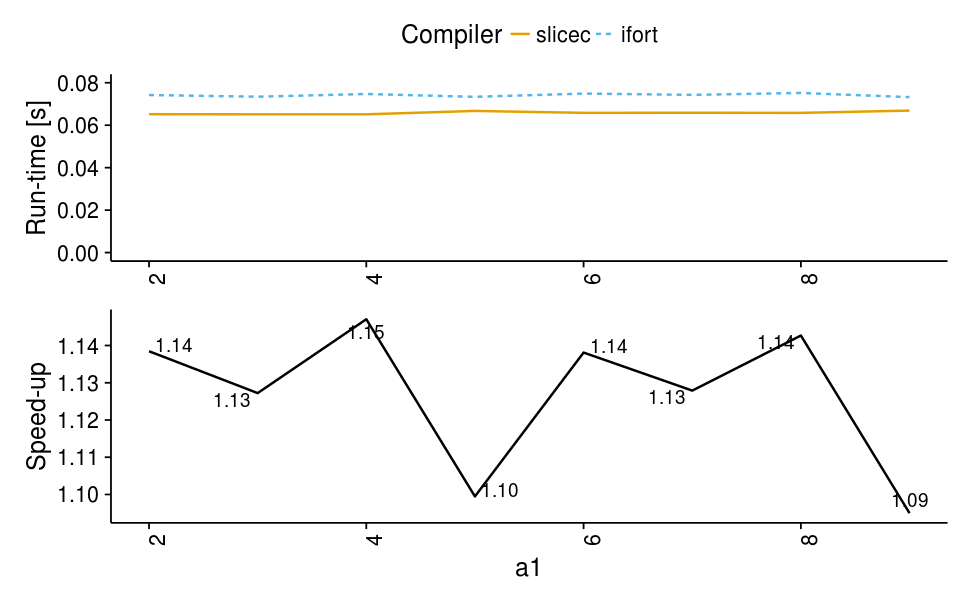

In [32]:
inner.melt <- melt(inner.speedup, measure.vars=c("mean.ifort", "mean.slicec"), 
              value.name = "mean.seconds", variable.name = "compiler")

p1 <- ggplot(inner.melt, aes(x=a1, y=mean.seconds, colour=compiler, linetype=compiler,
                       label=sprintf("%.2f", speedup))) +
    geom_line(size=0.7) +
  #  facet_grid( ~ x.var, scales = "free") +
    guides(colour=guide_legend("Compiler"), linetype=guide_legend("Compiler")) +
    scale_color_manual(values=colour.blind.friendly.values(),
                     labels=c("slicec", "ifort"),
                      limits=c("mean.slicec", "mean.ifort")) +
    scale_linetype_discrete(labels=c("slicec", "ifort"),
                      limits=c("mean.slicec", "mean.ifort")) +
    labs(x=NULL, y="Run-time [s]") +
    theme_cowplot(font_size=15) +
    theme(legend.position="top", panel.spacing = unit(0.2, "lines")) +
    rotate.x.ticks() + 
    ylim(0, 0.08)

library(ggrepel)
p2 <- ggplot(inner.melt, aes(x=a1, y=speedup,
                       label=sprintf("%.2f", speedup))) +
    geom_line(size=0.7) +
    geom_text_repel(stat="summary", fun.y="max", size=4) +
  #  facet_grid( ~ x.var, scales = "free") +
    guides(colour=guide_legend("Compiler"), linetype=guide_legend("Compiler")) +
    scale_color_manual(values=colour.blind.friendly.values(),
                     labels=c("slicec", "ifort"),
                      limits=c("mean.slicec", "mean.ifort")) +
    scale_linetype_discrete(labels=c("slicec", "ifort"),
                      limits=c("mean.slicec", "mean.ifort")) +
    labs(x="a1", y="Speed-up") +
    theme_cowplot(font_size=15) +
    theme(legend.position="top", panel.spacing = unit(0.2, "lines")) +
    theme(strip.background = element_blank(),
           strip.text.x = element_blank()) +
    rotate.x.ticks()

p <- plot_grid(p1, p2, align="v", nrow=2)
save_plot("inner-domain-v2.pdf", p, base_aspect_ratio = 1.7, device=cairo_pdf)
p

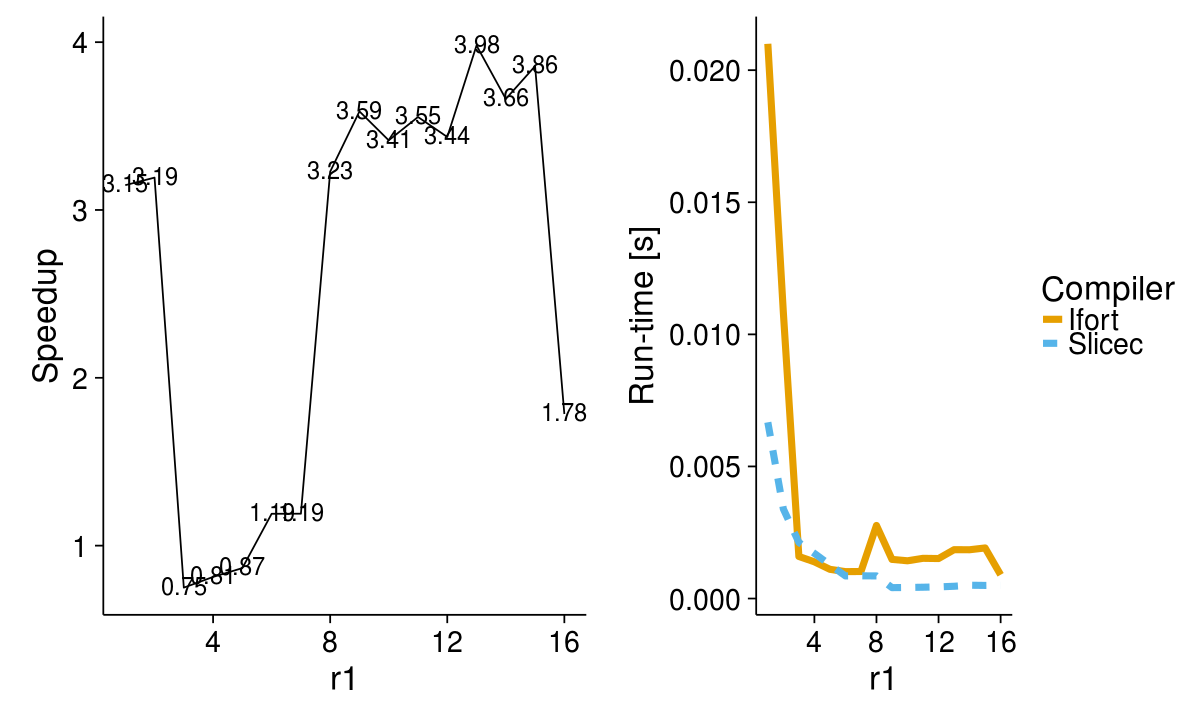

In [51]:
p1 <- ggplot(tb.speedup, aes(x=r1, y=speedup, label=sprintf("%.2f", speedup))) +
    geom_line() +
    geom_text(nudge_y = 0.01, hjust="center", size=5) +
    labs(y="Speedup") +
    theme_cowplot(font_size=20)
p2 <- ggplot(top.border, aes(x=r1, y=mean.seconds, colour=compiler, linetype=compiler)) + 
    stat_summary(fun.y="mean", geom="line", size=2) +
    guides(colour=guide_legend("Compiler"), linetype=guide_legend("Compiler")) +
      scale_color_manual(values=colour.blind.friendly.values(),
                     labels=c("Ifort", "Slicec")) +
    scale_linetype_discrete(labels=c("Ifort", "Slicec")) +
    labs(y="Run-time [s]") +
    theme_cowplot(font_size=20)
p <- plot_grid(p1, p2)
save_plot("top-border-2d-same-size.pdf", p, base_aspect_ratio=3)
set.plot.size(10, 6)
p

# Importance of optimizations

## Avoiding gather

In [4]:
r1 <- read.fort.exp.table("results/r1_space_sweep.org")
r2 <- read.fort.exp.table("results/r2_space_sweep.org")
b1 <- read.fort.exp.table("results/b1_space_sweep.org")
s1 <- read.fort.exp.table("results/s1_space_sweep.org")
n1u <- read.fort.exp.table("results/n1_unaligned.org")

r1g <- read.fort.exp.table("results/r1_space_sweep_gather.org")
r2g <- read.fort.exp.table("results/r2_space_sweep_gather.org")
b1g <- read.fort.exp.table("results/b1_space_sweep_gather.org")
s1g <- read.fort.exp.table("results/s1_space_sweep_gather.org")
n1ug <- read.fort.exp.table("results/n1_unaligned_gather.org")

r1.speedup <- calc.speedup(r1, "r1")
r1g.speedup <- calc.speedup(r1g, "r1")
r2.speedup <- calc.speedup(r2, "r2")
r2g.speedup <- calc.speedup(r2g, "r2")
b1.speedup <- calc.speedup(b1, "b1")
b1g.speedup <- calc.speedup(b1g, "b1")
s1.speedup <- calc.speedup(s1, "s1")
s1g.speedup <- calc.speedup(s1g, "s1")
n1u.speedup <- calc.speedup(n1u, "n1")
n1ug.speedup <- calc.speedup(n1ug, "n1")

r1.speedup$mean.slicec.gather <- NA #r1g.speedup$mean.slicec
r2.speedup$mean.slicec.gather <- NA #r2g.speedup$mean.slicec
b1.speedup$mean.slicec.gather <- b1g.speedup$mean.slicec
s1.speedup$mean.slicec.gather <- s1g.speedup$mean.slicec
n1u.speedup$mean.slicec.gather <- NA #n1ug.speedup$mean.slicec

r1.speedup$speedup.gather <- NA
r2.speedup$speedup.gather <- NA
b1.speedup$speedup.gather <- b1g.speedup$speedup
s1.speedup$speedup.gather <- s1g.speedup$speedup
n1u.speedup$speedup.gather <- NA

r1.speedup$x.var <- "r1"
r2.speedup$x.var <- "r2"
b1.speedup$x.var <- "b1"
s1.speedup$x.var <- "s1"
n1u.speedup$x.var <- "m1"

r1.speedup$x.val <- r1.speedup$r1
r2.speedup$x.val <- r2.speedup$r2
b1.speedup$x.val <- b1.speedup$b1
s1.speedup$x.val <-  s1.speedup$s1
n1u.speedup$x.val <- n1u.speedup$n1


combi.gather <- rbind(r1.speedup, r2.speedup, s1.speedup, b1.speedup, n1u.speedup)
combi.gather <- melt(combi.gather, measure.vars=c("mean.ifort", "mean.slicec", "mean.slicec.gather"), 
              value.name = "mean.seconds", variable.name = "compiler")

Warning message:
“Removed 63 rows containing non-finite values (stat_summary).”Warning message:
“Removed 63 rows containing non-finite values (stat_summary).”

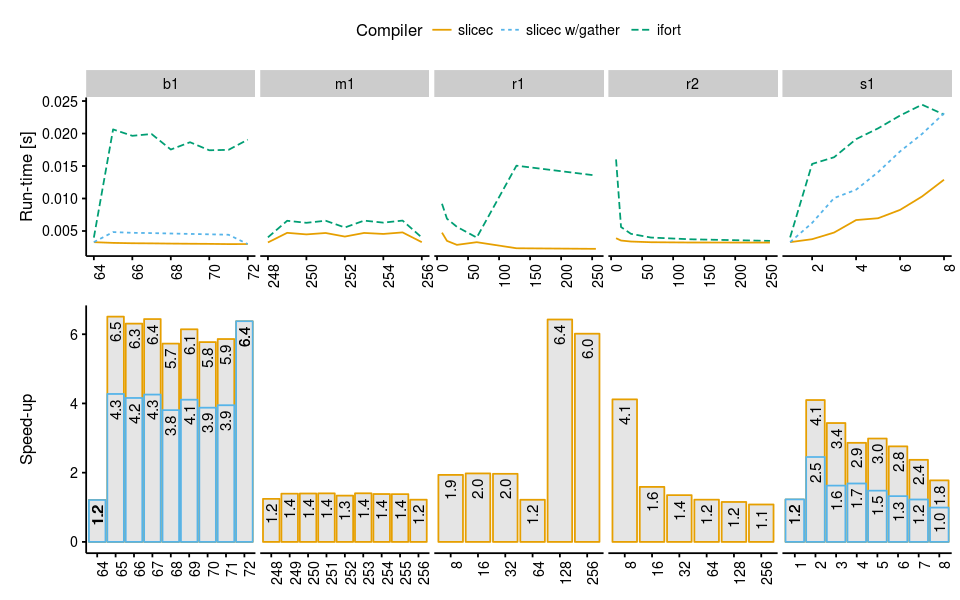

In [6]:

set.plot.size(8, 5)
p1 <- ggplot(combi.gather, aes(x=x.val, y=mean.seconds, colour=compiler, linetype=compiler,
                       label=sprintf("%.2f", speedup))) +
    geom_line(size=0.5) +
    facet_grid( ~ x.var, scales = "free") +
    guides(colour=guide_legend("Compiler"), linetype=guide_legend("Compiler")) +
    scale_color_manual(values=colour.blind.friendly.values(),
                     labels=c("mean.slicec"="slicec", "mean.slicec.gather"="slicec w/gather", "mean.ifort"="ifort"),
                      limits=c("mean.slicec", "mean.slicec.gather", "mean.ifort")) +
    scale_linetype_discrete(labels=c("mean.slicec"="slicec", "mean.slicec.gather"="slicec w/gather", "mean.ifort"="ifort"),
                           limits=c("mean.slicec", "mean.slicec.gather", "mean.ifort")) +
    labs(x=NULL, y="Run-time [s]") +
    theme_cowplot(font_size=10) +
    theme(legend.position="top", panel.spacing = unit(0.2, "lines")) +
    rotate.x.ticks()

library(ggrepel)
p2 <- ggplot(melt(combi.gather, measure.vars=c("speedup", "speedup.gather"), 
                  value.name = "speedup.val", variable.name = "slicec.version"),
             aes(x=factor(x.val), y=speedup.val, group=slicec.version,
                       label=ifelse(is.na(speedup.val), NA, sprintf("%.1f", speedup.val)))) +
    geom_bar(size=0.5, stat="summary", fun.y="mean", position="identity", aes(colour=slicec.version), fill="grey90") +
    geom_text(stat="summary", fun.y="max", size=3.2, angle=90, aes(y=speedup.val - 0.45), colour="black") +
    #geom_point(stat="summary", fun.y="mean", aes(colour=slicec.version)) + 
    #geom_line(stat="summary", fun.y="mean", aes(colour=slicec.version)) + 
    #geom_text(stat="summary", fun.y="max", size=3, angle=60, aes(y=speedup.val + 0.45), colour="black") +
    #geom_text_repel(stat="summary", fun.y="max", size=3,  colour="black") +
    facet_grid( ~ x.var, scales = "free") +
    #guides(colour=guide_legend("Compiler"), linetype=guide_legend("Compiler")) +
    guides(colour=FALSE, linetype=FALSE) +
    scale_fill_manual(values=colour.blind.friendly.values(),
                     labels=c("slicec", "slicec w/gather")) +
    scale_colour_manual(values=colour.blind.friendly.values(),
                     labels=c("slicec", "slicec w/gather")) +
    scale_linetype_discrete(labels=c("ifort", "slicec", "slicec w/gather")) +
    labs(x=NULL, y="Speed-up") +
    theme_cowplot(font_size=10) +
    theme(legend.position="top", panel.spacing = unit(0.2, "lines")) +
    theme(strip.background = element_blank(),
           strip.text.x = element_blank()) +
    rotate.x.ticks()

p <- plot_grid(p1, p2, align="v", nrow=2)
save_plot("space-sweep-w-gather.pdf", p, base_aspect_ratio=2, device=cairo_pdf)
p

## Prefetch quality

### Utility func

In [8]:
GCD <- function(a, b) {
    ifelse(b == 0, a, GCD(b, a %% b))
}

In [9]:
extend.w.slicec.selection <- function(orig, slicec) {
    slicec.L1 <- select(slicec, n1, r1, r2, compiler, slicec.dim=L1_prefetch_dim)
    dim.quality.plus <- left_join(orig, slicec.L1, by=c("n1", "r1", "r2", "compiler"))
    dim.quality.plus <- dim.quality.plus %>% mutate(
        L1_prefetch_dim = L1_prefetch_dim + 1,
        slicec.dim = slicec.dim + 1,
        conflict.period.L1 = 64/GCD(64, (n1%/%8)),
        conflict.period.L2 = 1024/GCD(1024, (n1%/%8)),
        is.slicec.selection = slicec.dim == L1_prefetch_dim)
    dim.quality.plus
}

### Case I: Dim 1 usefulness

Test case: `M(1:r1, 1:128, :)`, $4104 \times 128 \times n_3$, $r_1$ increasing.

The "competition" is dim. 2 prefetching. This is given optimal conditions as follows:
- With $n_2$ equal $r_2$, dim. 2 is not punished by validity.
- With $gcd(n_1, 64) = 1$, the conflict period is minimized (penalizing dim. 2 prefetching least).

In [10]:
#case.i <- filter(dim.quality.plus, r2 == 64 & conflict.period.L1 == 64)
case.i <- read.fort.exp.table("results/case_i_dim0.org")
case.i.slicec <- read.fort.exp.table("results/case_i_dim0_slicec_sel.org")
case.i.extra <- read.fort.exp.table("results/case_i_dim0_extra.org")
case.i.slicec.extra <- read.fort.exp.table("results/case_i_dim0_slicec_sel_extra.org")
case.i <- rbind(case.i, case.i.extra)
case.i.slicec <- rbind(case.i.slicec, case.i.slicec.extra)
case.i <- extend.w.slicec.selection(case.i, case.i.slicec)

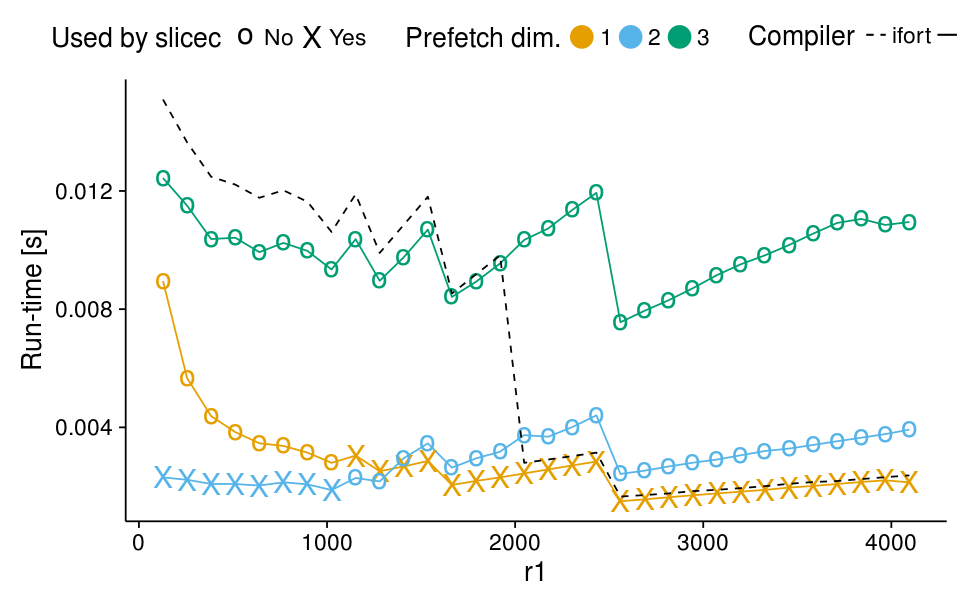

In [11]:
set.plot.size(8, 5)
p <- ggplot(case.i %>% filter(str_trim(compiler) == "slicec_s"), 
       aes(x = r1, y = mean.seconds, 
                   colour=as.factor(L1_prefetch_dim), shape=is.slicec.selection,
                  group=as.factor(L1_prefetch_dim), label=sprintf("%d", L2_prefetch_dist))) + 
    geom_line(stat="summary", fun.y="mean", aes(linetype="slicec"), size=0.5) + 
    #geom_text(stat="summary", fun.y="max") +
    geom_point(stat="summary", fun.y="mean", size=6) + 
    geom_line(data = case.i %>% filter(str_trim(compiler) == "ifort_s"),
              stat="summary", fun.y="mean", colour="black", aes(linetype="ifort", group=""), size=0.5) +
    scale_colour_manual(values=colour.blind.friendly.values()) +
    scale_shape_manual(values=c("TRUE"="X", "FALSE"="o"), labels=c("TRUE"="Yes", "FALSE"="No"))+
    scale_linetype_manual(values=c("slicec"="solid", "ifort"="dashed")) +
    theme_cowplot(font_size=16) +
    theme(legend.position="top") +
    guides(colour=guide_legend("Prefetch dim."), 
           shape=guide_legend("Used by slicec"),
           linetype = guide_legend("Compiler")) +#colour=guide_legend("Selected by slicec")) +
    labs(x="r1", y="Run-time [s]")
save_plot("case-i-dim1.pdf", p, base_aspect_ratio=2.3, device=cairo_pdf)
p

### Case ii: Dim 3 usefulness

Test case: `M(1:8, 1:r2, :)`, $8 \times 4104 \times n_3$, $r_2$ increasing.

The competitions is dim. 2 prefetching. 
- If the conflict period is minimized, then dim. 2 will be favored...

In [12]:
case.ii.and.iii <- read.fort.exp.table("results/case_iii_r2_n1.org")
case.ii.and.iii.slicec.sel <- read.fort.exp.table("results/case_iii_r2_n1_slicec_selection.org")
case.ii.and.iii <- extend.w.slicec.selection(case.ii.and.iii, case.ii.and.iii.slicec.sel)

In [13]:
# For case 2, make dim 3 as useless as possible by having a low conflict period.
case.ii <- filter(case.ii.and.iii, conflict.period.L2 == 64)

In [14]:
case.ii <- mutate(case.ii, `Bytes copied`=res.bytes)

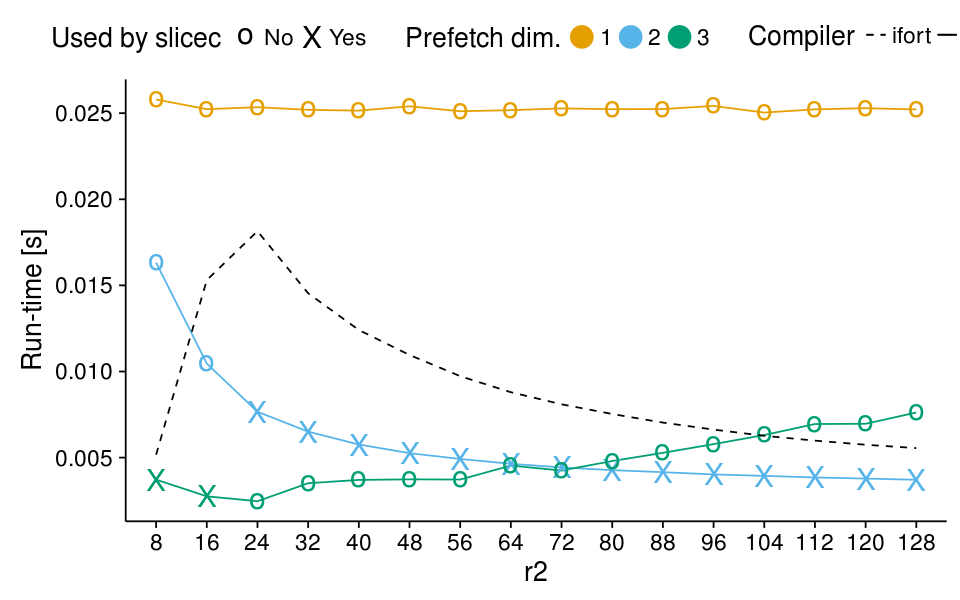

In [23]:
set.plot.size(8, 5)
p <- ggplot(case.ii %>% filter(str_trim(compiler) == "slicec_s"), 
       aes(x = as.factor(r2), y = mean.seconds, 
                   colour=as.factor(L1_prefetch_dim), shape=is.slicec.selection,
                  group=as.factor(L1_prefetch_dim))) + 
    geom_line(stat="summary", fun.y="mean", aes(linetype="slicec"), size=0.5) + 
    geom_point(stat="summary", fun.y="mean", size=6) + 
    geom_line(data = case.ii %>% filter(str_trim(compiler) == "ifort_s"),
              stat="summary", fun.y="mean", colour="black", aes(linetype="ifort", group=""), size=0.5) +
    scale_colour_manual(values=colour.blind.friendly.values()) +
    scale_shape_manual(values=c("TRUE"="X", "FALSE"="o"), labels=c("TRUE"="Yes", "FALSE"="No"))+
    scale_linetype_manual(values=c("slicec"="solid", "ifort"="dashed")) +
    theme_cowplot(font_size=16) +
    theme(legend.position="top") +
    guides(colour=guide_legend("Prefetch dim."), 
           shape=guide_legend("Used by slicec"),
           linetype = guide_legend("Compiler")) +#colour=guide_legend("Selected by slicec")) +
    labs(x="r2", y="Run-time [s]")
save_plot("case-ii-dim3.pdf", p, base_aspect_ratio=2.3, device=cairo_pdf)
p

In [16]:
case.ii.best <- read.fort.exp.table("results/case_ii_best.org")
case.ii.best.slicec.sel <- read.fort.exp.table("results/case_ii_best_slicec_selection.org")
case.ii.best <- extend.w.slicec.selection(case.ii.best, case.ii.best.slicec.sel)

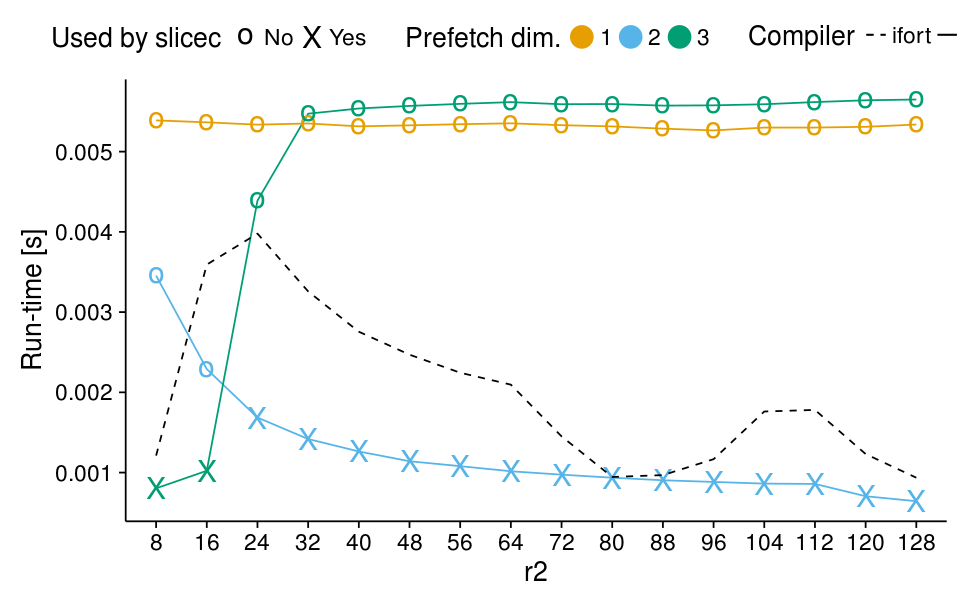

In [22]:
set.plot.size(8, 5)
p <- ggplot(case.ii.best %>% filter(str_trim(compiler) == "slicec_s"), 
       aes(x = as.factor(r2), y = mean.seconds, 
                   colour=as.factor(L1_prefetch_dim), shape=is.slicec.selection,
                  group=as.factor(L1_prefetch_dim))) + 
    geom_line(stat="summary", fun.y="mean", aes(linetype="slicec"), size=0.5) + 
    geom_point(stat="summary", fun.y="mean", size=6) + 
    geom_line(data = case.ii.best %>% filter(str_trim(compiler) == "ifort_s"),
              stat="summary", fun.y="mean", colour="black", aes(linetype="ifort", group=""), size=0.5) +
    scale_colour_manual(values=colour.blind.friendly.values()) +
    scale_shape_manual(values=c("TRUE"="X", "FALSE"="o"), labels=c("TRUE"="Yes", "FALSE"="No"))+
    scale_linetype_manual(values=c("slicec"="solid", "ifort"="dashed")) +
    theme_cowplot(font_size=16) +
    theme(legend.position="top") +
    guides(colour=guide_legend("Prefetch dim."), 
           shape=guide_legend("Used by slicec"),
           linetype = guide_legend("Compiler")) +#colour=guide_legend("Selected by slicec")) +
    labs(x="r2", y="Run-time [s]")
save_plot("case-ii-dim3-best.pdf", p, base_aspect_ratio=2.3, device=cairo_pdf)
p

### Case iii: 

In [19]:
case.iii <- case.ii.and.iii

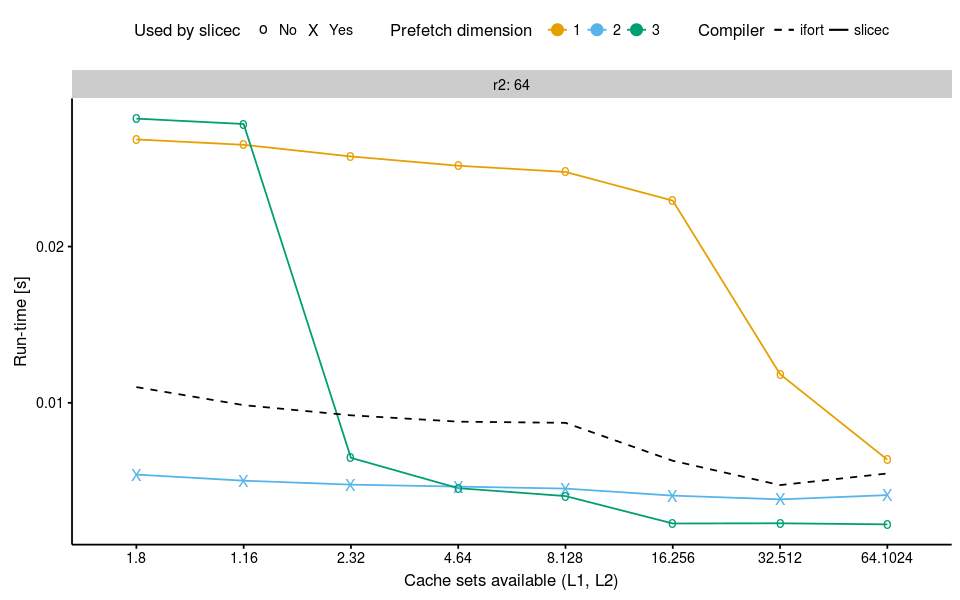

In [20]:
set.plot.size(8, 5)
p <- ggplot(case.iii %>% filter(str_trim(compiler) == "slicec_s" & r2 == 64), 
       aes(x = interaction(conflict.period.L1, conflict.period.L2), y = mean.seconds, 
                   colour=as.factor(L1_prefetch_dim), shape=is.slicec.selection,
                  group=as.factor(L1_prefetch_dim))) + 
    geom_line(stat="summary", fun.y="mean", aes(linetype="slicec")) + 
    geom_point(stat="summary", fun.y="mean", size=3) + 
    geom_line(data = case.iii %>% filter(str_trim(compiler) == "ifort_s" & r2 == 64),
              stat="summary", fun.y="mean", colour="black", aes(linetype="ifort", group="")) +
    scale_colour_manual(values=colour.blind.friendly.values()) +
    scale_shape_manual(values=c("TRUE"="X", "FALSE"="o"), labels=c("TRUE"="Yes", "FALSE"="No"))+
    scale_linetype_manual(values=c("slicec"="solid", "ifort"="dashed")) +
    theme_cowplot(font_size=10) +
    theme(legend.position="top") +
    guides(colour=guide_legend("Prefetch dimension"), 
           shape=guide_legend("Used by slicec"),
           linetype = guide_legend("Compiler")) +#colour=guide_legend("Selected by slicec")) +
    labs(x="Cache sets available (L1, L2)", y="Run-time [s]") +
    facet_grid(~r2, labeller=label_both)
    # scale_x_continuous(trans="log2")
#save_plot("case-i-dim0.pdf", p, base_aspect_ratio=2)
p

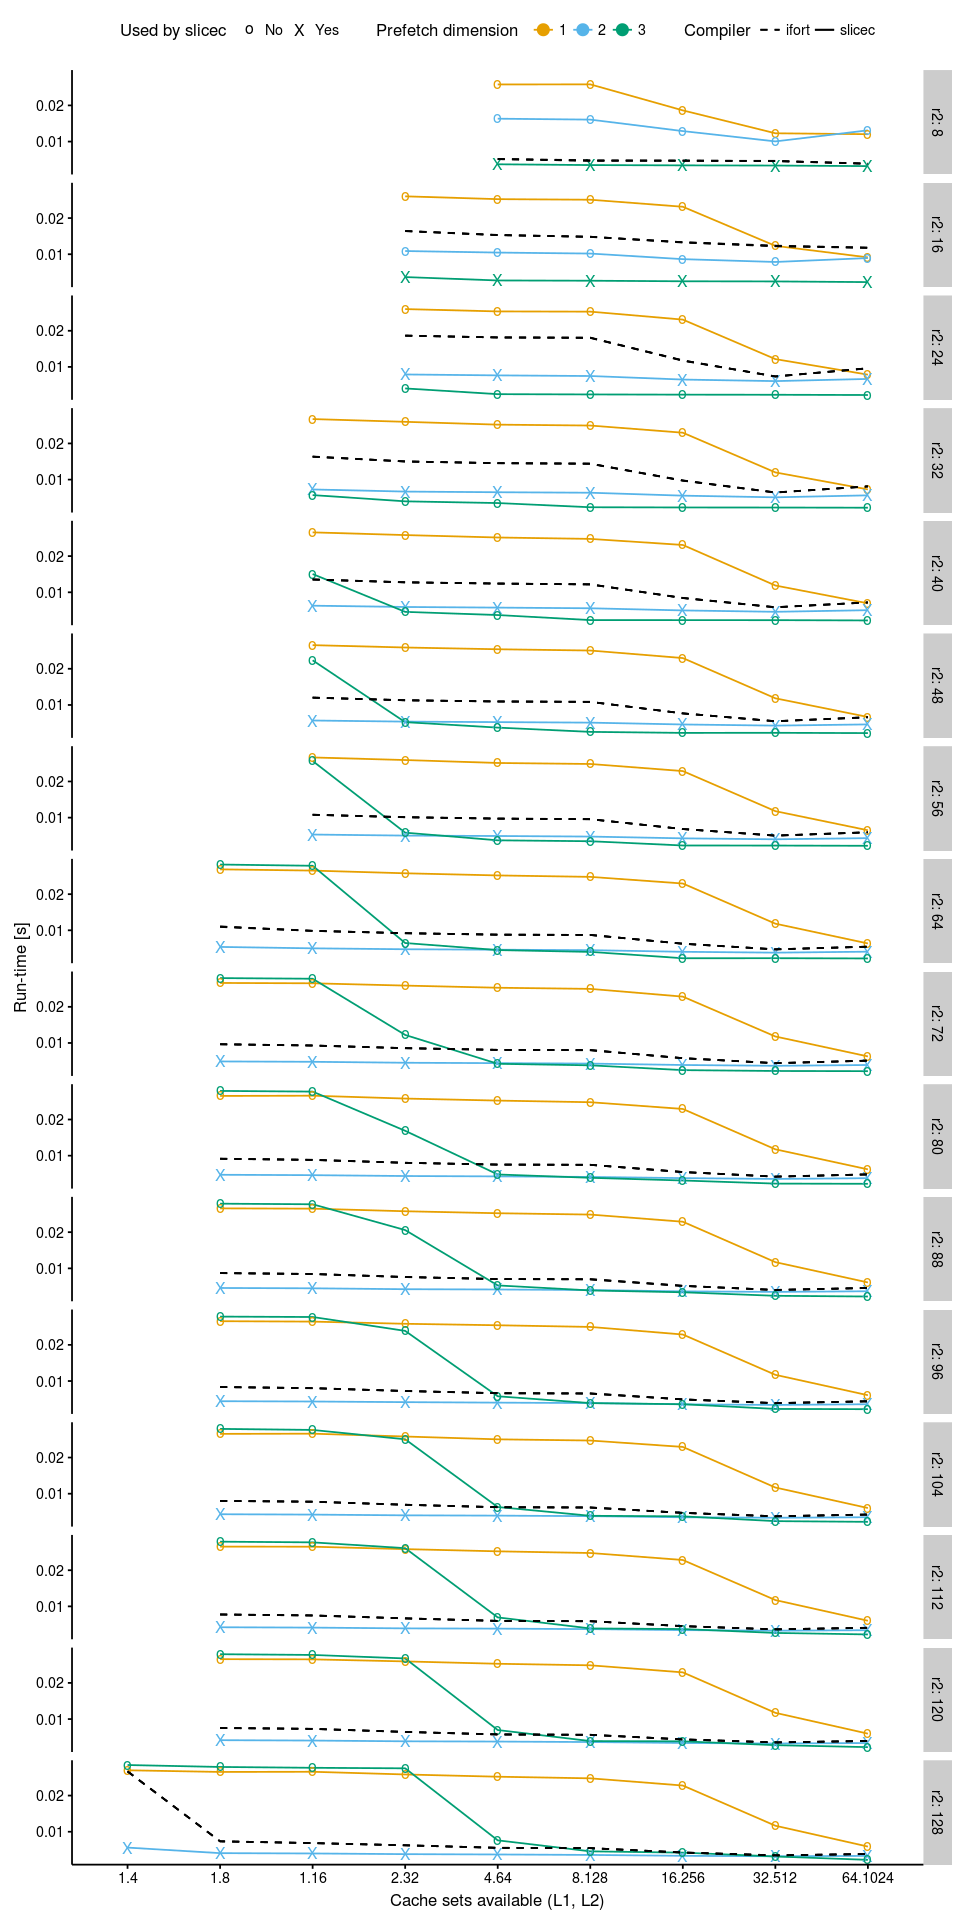

In [21]:
set.plot.size(8, 16)
p <- ggplot(case.iii %>% filter(str_trim(compiler) == "slicec_s"), 
       aes(x = interaction(conflict.period.L1, conflict.period.L2), y = mean.seconds, 
                   colour=as.factor(L1_prefetch_dim), shape=is.slicec.selection,
                  group=as.factor(L1_prefetch_dim))) + 
    geom_line(stat="summary", fun.y="mean", aes(linetype="slicec")) + 
    geom_point(stat="summary", fun.y="mean", size=3) + 
    geom_line(data = case.iii %>% filter(str_trim(compiler) == "ifort_s"),
              stat="summary", fun.y="mean", colour="black", aes(linetype="ifort")) +
    scale_colour_manual(values=colour.blind.friendly.values()) +
    scale_shape_manual(values=c("TRUE"="X", "FALSE"="o"), labels=c("TRUE"="Yes", "FALSE"="No"))+
    scale_linetype_manual(values=c("slicec"="solid", "ifort"="dashed")) +
    theme_cowplot(font_size=10) +
    theme(legend.position="top") +
    guides(colour=guide_legend("Prefetch dimension"), 
           shape=guide_legend("Used by slicec"),
           linetype = guide_legend("Compiler")) +#colour=guide_legend("Selected by slicec")) +
    labs(x="Cache sets available (L1, L2)", y="Run-time [s]") +  
    facet_grid(r2 ~ ., labeller=label_both)
p

In [25]:
case.iii.v2 <- read.fort.exp.table("results/case_iii_deeper.org")
case.iii.v2.slicec.sel <- read.fort.exp.table("results/case_iii_deeper_slicec_selection.org")
case.iii.v2 <- extend.w.slicec.selection(case.iii.v2, case.iii.v2.slicec.sel)
case.iii.v2 <- case.iii.v2 %>% mutate(`Bytes copied`=res.bytes)

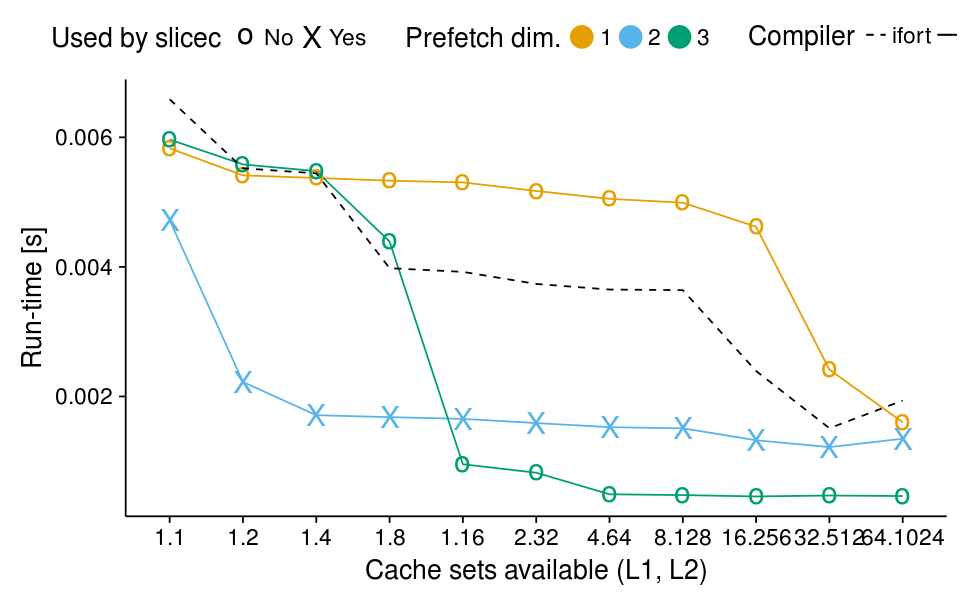

In [26]:
set.plot.size(8, 5)
p <- ggplot(case.iii.v2 %>% filter(str_trim(compiler) == "slicec_s"), 
       aes(x = interaction(conflict.period.L1, conflict.period.L2), y = mean.seconds, 
                   colour=as.factor(L1_prefetch_dim), shape=is.slicec.selection,
                  group=as.factor(L1_prefetch_dim))) + 
    geom_line(stat="summary", fun.y="mean", aes(linetype="slicec"), size=0.5) + 
    geom_point(stat="summary", fun.y="mean", size=6) + 
    geom_line(data = case.iii.v2 %>% filter(str_trim(compiler) == "ifort_s"),
              stat="summary", fun.y="mean", colour="black", aes(linetype="ifort", group=""), size=0.5) +
    scale_colour_manual(values=colour.blind.friendly.values()) +
    scale_shape_manual(values=c("TRUE"="X", "FALSE"="o"), labels=c("TRUE"="Yes", "FALSE"="No"))+
    scale_linetype_manual(values=c("slicec"="solid", "ifort"="dashed")) +
    theme_cowplot(font_size=16) +
    theme(legend.position="top") +
    guides(colour=guide_legend("Prefetch dim."), 
           shape=guide_legend("Used by slicec"),
           linetype = guide_legend("Compiler")) +#colour=guide_legend("Selected by slicec")) +
    labs(x="Cache sets available (L1, L2)", y="Run-time [s]")# +
    #facet_grid(~r2 + `Bytes copied`, labeller=label_both)
    # scale_x_continuous(trans="log2")
save_plot("case-iii-dim3-conflict.pdf", p, base_aspect_ratio=2.3, device=cairo_pdf)
p